# Comparing Metric to Dataset Analysis - PCA

TJ Kim <br/>
3/28/21

Updated <br/>
4/1/21

#### Objective: 
Directly compare the adversarial attack data vs non: <br/>

Deliverables
- Same tables as PPT made in 3/9 dividing data points by attack success and analyzing by their metrics
- Gaussian Attribution L2 Distance
- PCA visualization for 4 class (2 class + success of attack) division and metric analysis

In [1]:
cd '/home/ubuntu/FedAtk/' 

/home/ubuntu/FedAtk


### Load Relevant Libraries and Modules

Load the relevant libraries for the federated learning code.

In [2]:
from transfer_attacks.DA_Transferer import *

import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import csv
import os
import pickle
from torch.autograd import Variable
import copy
import pandas as pd

### Load Model and data

In [5]:
# Make directory in results for this experiment
# FL Architecture
client_idx = 0
victim_idxs = [1]
ifgsm_iterations = [1,3,5,10,20]
batch_size = 200

# Saved Neural Networks to Test on 
exp_names = ["exp4_neck2_0_head3"]

# Parameters to record for excel printing
num_clients = len(victim_idxs)
metrics = ['orig_acc','orig_sim','orig_acc_robust', 'orig_sim_robust', 
           'orig_acc_adv', 'orig_sim_adv','adv_sim','adv_hit','g_align',
           'g_align_robust', 'g_align_adv']

# Save 3 - neck2_head3 ifsgm iteration sweep
stored_fgsm_iteration = {}
stored_fgsm_iteration['iterations'] = ifgsm_iterations
for i in metrics:
    stored_fgsm_iteration[i] = np.zeros(len(ifgsm_iterations))

In [6]:
transferer = DA_Transferer(filename = exp_names[0])
transferer.generate_advNN(client_idx = client_idx)
transferer.generate_victims(client_idxs = victim_idxs)
transferer.load_niid_data(clients=victim_idxs)

transferer.ifsgm_params.set_params(batch_size = batch_size)

Loading  all_data_12_niid_0_keep_0_train_9.json
Loading  all_data_20_niid_0_keep_0_train_9.json
Loading  all_data_11_niid_0_keep_0_train_9.json
Loading  all_data_18_niid_0_keep_0_train_9.json
Loading  all_data_0_niid_0_keep_0_train_9.json
Loading  all_data_34_niid_0_keep_0_train_9.json
Loading  all_data_17_niid_0_keep_0_train_9.json
Loading  all_data_13_niid_0_keep_0_train_9.json


### Perform attack and log

In [5]:
for it in range(len(ifgsm_iterations)):
    transferer.ifsgm_params.set_params(iteration = ifgsm_iterations[it])
    transferer.generate_xadv(atk_type = "ifsgm")
    transferer.send_to_victims(victim_idxs)
    transferer.check_empirical_metrics(orig_flag = True)
    
    stored_fgsm_iteration['orig_acc'][it] = sum(transferer.orig_acc_transfers.values()) / len(transferer.orig_acc_transfers) 
    stored_fgsm_iteration['orig_sim'][it] = sum(transferer.orig_similarities.values())/ len(transferer.orig_similarities)
    stored_fgsm_iteration['adv_sim'][it] = sum(transferer.adv_similarities.values())/ len(transferer.adv_similarities)
    stored_fgsm_iteration['adv_hit'][it] = sum(transferer.adv_target_hit.values())/len(transferer.adv_target_hit)
    stored_fgsm_iteration['g_align'][it] = sum(transferer.metric_alignment.values())/len(transferer.metric_alignment)
    
    stored_fgsm_iteration['orig_acc_robust'][it] = sum(transferer.orig_acc_transfers_robust.values()) / len(transferer.orig_acc_transfers_robust) 
    stored_fgsm_iteration['orig_sim_robust'][it] = sum(transferer.orig_similarities_robust.values())/ len(transferer.orig_similarities_robust)
    stored_fgsm_iteration['orig_acc_adv'][it] = sum(transferer.orig_acc_transfers_adv.values()) / len(transferer.orig_acc_transfers_adv) 
    stored_fgsm_iteration['orig_sim_adv'][it] = sum(transferer.orig_similarities_adv.values())/ len(transferer.orig_similarities_adv)
    
    stored_fgsm_iteration['g_align_robust'][it] = sum(transferer.metric_alignment_robust.values())/len(transferer.metric_alignment_robust)
    stored_fgsm_iteration['g_align_adv'][it] = sum(transferer.metric_alignment_adv.values())/len(transferer.metric_alignment_adv)

    
    print('finished fgsm iter sweep', it)
    
df3 = pd.DataFrame(data=stored_fgsm_iteration).T
df3

finished fgsm iter sweep 0
finished fgsm iter sweep 1
finished fgsm iter sweep 2
finished fgsm iter sweep 3
finished fgsm iter sweep 4


,0,1,2,3,4
iterations,1.000000,3.000000,5.000000,10.000000,20.000000
orig_acc,0.780000,0.780000,0.780000,0.780000,0.780000
orig_sim,0.570000,0.570000,0.570000,0.570000,0.570000
orig_acc_robust,0.778894,0.781726,0.795699,0.839286,0.849462
orig_sim_robust,0.567839,0.563452,0.559140,0.625000,0.677419
orig_acc_adv,1.000000,0.666667,0.571429,0.704545,0.719626
orig_sim_adv,1.000000,1.000000,0.714286,0.500000,0.476635
adv_sim,0.485000,0.230000,0.105000,0.440000,0.535000
adv_hit,0.005000,0.015000,0.070000,0.440000,0.535000
g_align,1.291331,1.088769,1.026493,1.142193,1.147927


### PCA Analysis

Slightly redundant but rerun attack for separate sections.

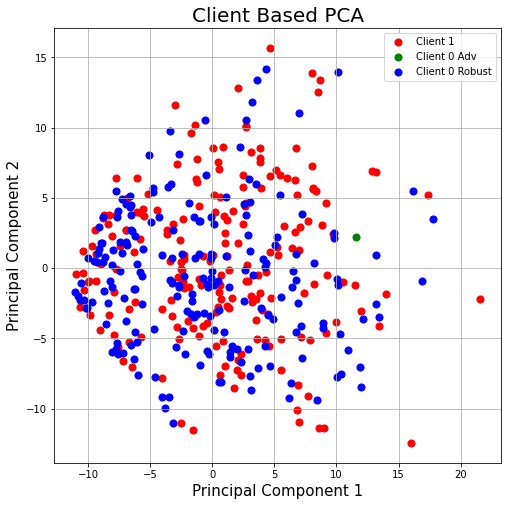

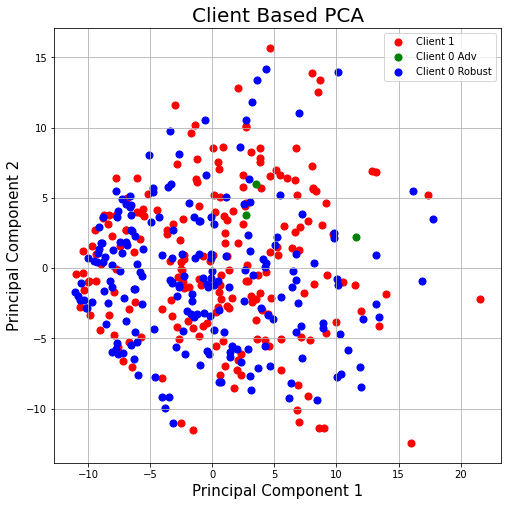

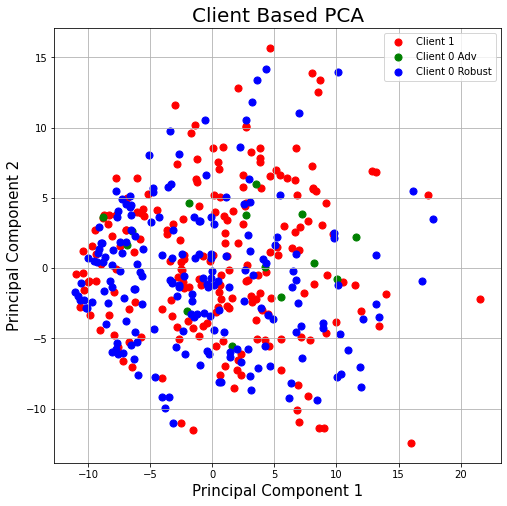

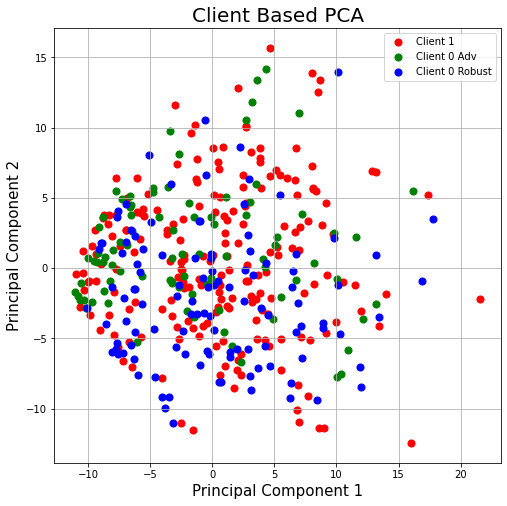

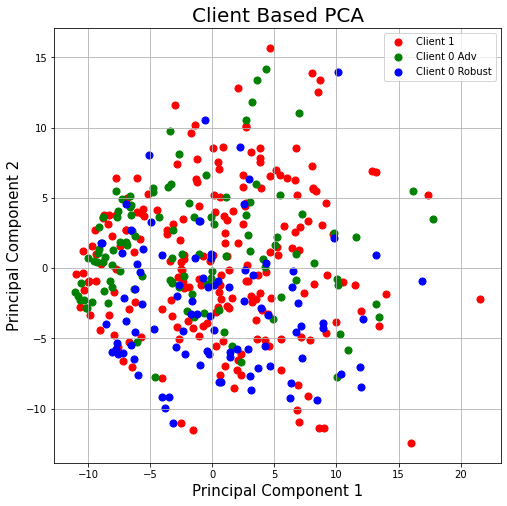

In [11]:
for it in range(len(ifgsm_iterations)):
    
    transferer.ifsgm_params.set_params(iteration = ifgsm_iterations[it])
    transferer.generate_xadv(atk_type = "ifsgm")
    transferer.send_to_victims(victim_idxs)
    transferer.check_empirical_metrics(orig_flag = True)

    transferer.set_data(mode='client', datasets = victim_idxs, batch_size = batch_size)
    transferer.set_data_advNN()
    transferer.forward_pass()
    transferer.obtain_PCA(analyze_atk = True, advrobust_idx = 1, dim=2)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('Client Based PCA', fontsize = 20)


    target_labels = ['Client 1', 'Client 0 Adv', 'Client 0 Robust']
    targets = [[victim_idxs[0],0],[victim_idxs[0],1],[victim_idxs[0],2]]
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        idx_temp0 = transferer.PCA_data['labels'][:,0] == target[0]
        idx_temp1 = transferer.PCA_data['labels'][:,1] == target[1]

        indicesToKeep = idx_temp0 * idx_temp1
        
        ax.scatter(transferer.PCA_data['data'][indicesToKeep,0]
                   , transferer.PCA_data['data'][indicesToKeep,1]
                   , c = color
                   , s = 50)
    ax.legend(target_labels)
    ax.grid()

In [12]:
# Make directory in results for this experiment
exp_name = '21_3_28 Experiment - PCA with Robust ADV Iterations'
exp_path = "results/" + exp_name
if not os.path.isdir(exp_path):
    os.mkdir(exp_path)
    

df3 = pd.DataFrame(data=stored_fgsm_iteration).T
df3.to_excel(exp_path + '/' + 'c'+str(client_idx)+'_s3_fgsm_iterations.xlsx',header=False)
